In [2]:
import pandas as pd
import kagglehub

# download the dataset (zipped into a local path)
path = kagglehub.dataset_download("blastchar/telco-customer-churn")
print("Dataset path:", path)

# load the csv
df = pd.read_csv(f"{path}/WA_Fn-UseC_-Telco-Customer-Churn.csv")
print(df.shape)
df.head()


100%|████████████████████████████████████████| 172k/172k [00:00<00:00, 5.30MB/s]

Extracting files...
Dataset path: /Users/anandhiraghuraman/.cache/kagglehub/datasets/blastchar/telco-customer-churn/versions/1
(7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [3]:
# Missing values & types
df.info()
df.isna().sum()

# Churn rate
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})
print("Churn rate:", df['Churn'].mean())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [4]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'] = df['TotalCharges'].fillna(df['TotalCharges'].median())

# Drop ID
df = df.drop(columns=['customerID'])


In [5]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=['Churn'])
y = df['Churn']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


In [6]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

num_features = X_train.select_dtypes(include=['int64','float64']).columns
cat_features = X_train.select_dtypes(include=['object']).columns

numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer([
    ("num", numeric_transformer, num_features),
    ("cat", categorical_transformer, cat_features)
])


In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score

# Logistic regression
pipe_lr = Pipeline([("preprocess", preprocess),
                    ("clf", LogisticRegression(max_iter=1000))])
pipe_lr.fit(X_train, y_train)
y_pred_lr = pipe_lr.predict(X_test)
print("Logistic Regression ROC-AUC:", roc_auc_score(y_test, pipe_lr.predict_proba(X_test)[:,1]))
print(classification_report(y_test, y_pred_lr))

# Random forest
pipe_rf = Pipeline([("preprocess", preprocess),
                    ("clf", RandomForestClassifier(n_estimators=300, random_state=42))])
pipe_rf.fit(X_train, y_train)
y_pred_rf = pipe_rf.predict(X_test)
print("Random Forest ROC-AUC:", roc_auc_score(y_test, pipe_rf.predict_proba(X_test)[:,1]))
print(classification_report(y_test, y_pred_rf))


Logistic Regression ROC-AUC: 0.8418739827946988
              precision    recall  f1-score   support

           0       0.85      0.89      0.87      1035
           1       0.66      0.56      0.60       374

    accuracy                           0.81      1409
   macro avg       0.75      0.73      0.74      1409
weighted avg       0.80      0.81      0.80      1409

Random Forest ROC-AUC: 0.8171458833862926
              precision    recall  f1-score   support

           0       0.83      0.89      0.85      1035
           1       0.60      0.48      0.54       374

    accuracy                           0.78      1409
   macro avg       0.71      0.68      0.70      1409
weighted avg       0.77      0.78      0.77      1409



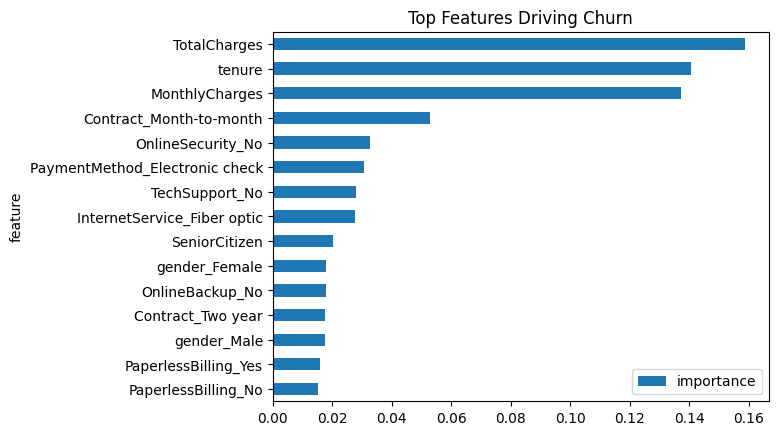

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# Extract one-hot feature names
ohe = pipe_rf.named_steps['preprocess'].named_transformers_['cat'].named_steps['onehot']
cat_names = ohe.get_feature_names_out(cat_features)
all_features = list(num_features) + list(cat_names)

importances = pipe_rf.named_steps['clf'].feature_importances_
imp_df = pd.DataFrame({'feature': all_features, 'importance': importances})
imp_df = imp_df.sort_values('importance', ascending=False).head(15)

imp_df.plot(x='feature', y='importance', kind='barh')
plt.gca().invert_yaxis()
plt.title("Top Features Driving Churn")
plt.show()
